<a href="https://colab.research.google.com/github/alejomd17/Analisis_Exploratorio_de_Datos_Espaciales_AEDE/blob/main/AEDE_en_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrucciones del ejercicio
Autor: Jorge Alejandro Moscoso Deossa

Notebook de Python en CoLab donde:
- Se presenta un mapa coropleto de el 1) déficit cuantitativo de vivienda en 2005 2) la tasa de mortalidad en menores de 1 año nacidos vivos en 2016. Ambas, variables están disponibles en el sitio web del DANE.
- Se calcula el esadístico global de Moran y presentar el diagrama de dispersión de Moran de ambas variables.
- Se presenta el mapa de clusters LISA para cada variable con un umbral de significancia del 5%
- Se calcula el estadístico bivariado de Moran entre el déficit de cuantitativo de Vivienda y la tasa de mortalidad infantil.
- Se interpretan los resultados

Región elegida:
Cundinamarca, Boyacá, Meta, Casanare, Arauca.

El desarrollo del ejercicio y su explicación se encuentra en el contenido de todo el Notebook.

Quedo atento a sus comentarios.

# Obtención de datos y organización de los data.frame

### Instalar paquetes de Mapas coropletos y LISA

In [ ]:
# Instalar paquetes de Mapas coropletos y LISA

%%time 
# Bibliotequa GDAL (Geospatial Data Abstraction Library)
!apt install gdal-bin python-gdal python3-gdal --quiet
# Instalar rtree - Requerido por Geopandas
!apt install python3-rtree --quiet
# Instalar descartes - Requerido por Geopandas
!pip install descartes --quiet
# Instalar Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet

# Install geovisualization libraries
!pip install folium  --quiet
!pip install plotly_express  --quiet
!pip install mapclassify --quiet

# Install Pysal - Spatial Statistics
!pip install pysal --quiet
!pip install splot --quiet

!pip install pytest --quiet
!pip install pytest-cov --quiet

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 6 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 h

In [ ]:
# Cargar paquetes

# Procesamiento de datos espaciales
import pandas as pd 
import geopandas as gpd
import fiona
from shapely.geometry import Point

# Funciones matemàticas
import numpy as np

# Producciòn de gráficos y mapas
import matplotlib.pyplot as plt 
%matplotlib inline
import folium
import plotly
import plotly_express as px
import seaborn as sns

# AEDE
from libpysal.weights import Queen, attach_islands, KNN
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from pysal.explore import esda
from pysal.lib import weights
import pysal as ps



### Montar Drive

In [ ]:
# Estructura para obtener y cargar datos
# 'https://drive.google.com/uc?export=download&id=INSERTE_ID_DE_ARCHIVO_AQUÍ'

# Shape de Colombia
# https://drive.google.com/file/d/1Wjzr-126Y6bKbiOcRPx0h07p1-lKUYuQ/view?usp=sharing
!wget 'https://drive.google.com/uc?export=download&id=1Wjzr-126Y6bKbiOcRPx0h07p1-lKUYuQ' -O colMun.zip


--2020-10-12 21:38:28--  https://drive.google.com/uc?export=download&id=1Wjzr-126Y6bKbiOcRPx0h07p1-lKUYuQ
Resolving drive.google.com (drive.google.com)... 74.125.20.138, 74.125.20.100, 74.125.20.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vv09b06l6ht7o20rvhja1o48rfme9dl1/1602538650000/11543759890386875759/*/1Wjzr-126Y6bKbiOcRPx0h07p1-lKUYuQ?e=download [following]
--2020-10-12 21:38:31--  https://doc-0g-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vv09b06l6ht7o20rvhja1o48rfme9dl1/1602538650000/11543759890386875759/*/1Wjzr-126Y6bKbiOcRPx0h07p1-lKUYuQ?e=download
Resolving doc-0g-1o-docs.googleusercontent.com (doc-0g-1o-docs.googleusercontent.com)... 142.250.99.132, 2607:f8b0:400e:c0c::84
Connecting to doc-0g-1o-docs.googleusercontent.com (doc-0g-1o-

In [ ]:
# Extraiga datos de archivo comprimido
!unzip colMun.zip

Archive:  colMun.zip
  inflating: colMun.dbf              
  inflating: colMun.prj              
  inflating: colMun.shp              
  inflating: colMun.shx              


In [ ]:
# Leer shape
col = gpd.read_file('colMun.shp')
col.columns.values

array(['OBJECTID', 'codigo', 'AREA_OFICI', 'ENTIDAD_TE', 'NOM_DEPART',
       'NOM_MUNICI', 'COD_DEPTO', 'SHAPE_area', 'SHAPE_len', 'DIVIPOLA',
       'geometry'], dtype=object)

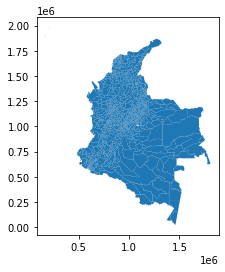

In [ ]:
# Grafique shape
col.plot()

### Cargar datos

In [ ]:
# Obtenga datos: DeficitCuantitativo2005
# https://drive.google.com/file/d/107_KpJwH1TQpgkdpImKSfkTuwpi6atcO/view?usp=sharing
!wget 'https://drive.google.com/uc?export=download&id=107_KpJwH1TQpgkdpImKSfkTuwpi6atcO' -O DeficitCuantitativo2005.csv

--2020-10-12 21:38:35--  https://drive.google.com/uc?export=download&id=107_KpJwH1TQpgkdpImKSfkTuwpi6atcO
Resolving drive.google.com (drive.google.com)... 74.125.195.113, 74.125.195.101, 74.125.195.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hl35qt3btf87pldi7bl3ek3528341aek/1602538650000/11543759890386875759/*/107_KpJwH1TQpgkdpImKSfkTuwpi6atcO?e=download [following]
--2020-10-12 21:38:35--  https://doc-0o-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hl35qt3btf87pldi7bl3ek3528341aek/1602538650000/11543759890386875759/*/107_KpJwH1TQpgkdpImKSfkTuwpi6atcO?e=download
Resolving doc-0o-1o-docs.googleusercontent.com (doc-0o-1o-docs.googleusercontent.com)... 142.250.99.132, 2607:f8b0:400e:c0c::84
Connecting to doc-0o-1o-docs.googleusercontent.com (doc-0o

In [ ]:
# Obtenga datos: TMI2016
# https://drive.google.com/file/d/1lFytjHoeTbnwpWrQs148pEbhYvPY0jnm/view?usp=sharing
!wget 'https://drive.google.com/uc?export=download&id=1lFytjHoeTbnwpWrQs148pEbhYvPY0jnm' -O TMI2016.csv

--2020-10-12 21:38:35--  https://drive.google.com/uc?export=download&id=1lFytjHoeTbnwpWrQs148pEbhYvPY0jnm
Resolving drive.google.com (drive.google.com)... 74.125.20.100, 74.125.20.138, 74.125.20.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jbp2p1fanjng58aau8ufdmq0mrbjd0h4/1602538650000/11543759890386875759/*/1lFytjHoeTbnwpWrQs148pEbhYvPY0jnm?e=download [following]
--2020-10-12 21:38:36--  https://doc-0c-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jbp2p1fanjng58aau8ufdmq0mrbjd0h4/1602538650000/11543759890386875759/*/1lFytjHoeTbnwpWrQs148pEbhYvPY0jnm?e=download
Resolving doc-0c-1o-docs.googleusercontent.com (doc-0c-1o-docs.googleusercontent.com)... 142.250.99.132, 2607:f8b0:400e:c0c::84
Connecting to doc-0c-1o-docs.googleusercontent.com (doc-0c-1o-

In [ ]:
# Leer datos DeficitCuantitativo2005
DeficitCuantitativo2005 = pd.read_csv('DeficitCuantitativo2005.csv',sep=';',encoding='latin')
DeficitCuantitativo2005.columns.values

array(['Código_Dep', 'Nombre_Dep', 'codigo', 'Nombre_Mun', 'Total ',
       'Porcentaje'], dtype=object)

In [ ]:
# Leer datos TMI2016
TMI2016 = pd.read_csv('TMI2016.csv',sep=';',encoding='latin')
TMI2016.columns.values

array(['codigo', 'Municipio', '2016'], dtype=object)

In [ ]:
# Inspeccione base de datos
col.sample(3)

,OBJECTID,codigo,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,SHAPE_area,SHAPE_len,DIVIPOLA,geometry
927,931,15218,104.0,Cabecera Municipal,BOYACÁ,COVARACHÍA,15,1.023038e+08,51662.316369,15218,"POLYGON ((1140312.694 1215463.352, 1140368.509..."
1005,1011,18094,1095.0,Cabecera Municipal,CAQUETÁ,BELÉN DE LOS ANDAQUÍES,18,1.145944e+09,198513.985355,18094,"POLYGON ((813057.066 623442.844, 812987.780 62..."
155,156,54670,387.0,Cabecera Municipal,NORTE DE SANTANDER,SAN CALIXTO,54,3.993324e+08,143564.612413,54670,"POLYGON ((1088813.979 1412482.469, 1088708.841..."


In [ ]:
# Inspeccione base de datos
DeficitCuantitativo2005.sample(3)

,Código_Dep,Nombre_Dep,codigo,Nombre_Mun,Total,Porcentaje
677,47,Magdalena,47707,Santa Ana,1144.73,26.15
438,23,Córdoba,23464,Momil,279.00,9.18
976,73,Tolima,73349,Honda,650.96,8.70


In [ ]:
# Inspeccione base de datos
TMI2016.sample(3)

,codigo,Municipio,2016
1067,85315,Sácama,30.594066
25,5125,Caicedo,19.645791
531,25596,Quipile,21.241344


### Cruzar Datos

In [ ]:
### Cruzar datos ColDeficitCuantitativo2005
# Inspeccione tipos de variables
print('Tipos de columna en <<col>>\n\n', col.dtypes,'\n\n')
print('Tipos de columna en <<DeficitCuantitativo2005>>\n\n', DeficitCuantitativo2005.dtypes)
print('Tipos de columna en <<TMI2016>>\n\n', TMI2016.dtypes)

Tipos de columna en <<col>>

 OBJECTID        object
codigo          object
AREA_OFICI     float64
ENTIDAD_TE      object
NOM_DEPART      object
NOM_MUNICI      object
COD_DEPTO       object
SHAPE_area     float64
SHAPE_len      float64
DIVIPOLA        object
geometry      geometry
dtype: object 


Tipos de columna en <<DeficitCuantitativo2005>>

 Código_Dep      int64
Nombre_Dep     object
codigo          int64
Nombre_Mun     object
Total         float64
Porcentaje    float64
dtype: object
Tipos de columna en <<TMI2016>>

 codigo         int64
Municipio     object
2016         float64
dtype: object


In [ ]:
#  Convierto 'codigo' en integer
col.codigo = col.codigo.astype('int')
col.codigo.dtypes

dtype('int64')

In [ ]:
# Cruzar datos. Col_DeficitCuantitativo
colDeficitCuantitativo2005 = col.merge(DeficitCuantitativo2005,on='codigo',how='inner')
colDeficitCuantitativo2005.shape

(1118, 16)

In [ ]:
Colombia=col.merge(DeficitCuantitativo2005,on='codigo',how='inner')
Colombia=Colombia.merge(TMI2016,on='codigo',how='inner')
Colombia.shape

(1118, 18)

In [ ]:
Colombia.sample(3)

,OBJECTID,codigo,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,SHAPE_area,SHAPE_len,DIVIPOLA,geometry,Código_Dep,Nombre_Dep,Nombre_Mun,Total,Porcentaje,Municipio,2016
307,308,25430,120.0,Cabecera Municipal,CUNDINAMARCA,MADRID,25,1.215297e+08,65584.131002,25430,"POLYGON ((979453.418 1024629.087, 979526.585 1...",25,Cundinamarca,Madrid,7020.04,42.59,Madrid,11.043218
784,790,15491,53.0,Cabecera Municipal,BOYACÁ,NOBSA,15,5.401973e+07,32622.895796,15491,"POLYGON ((1125710.469 1134028.031, 1125709.733...",15,Boyacá,Nobsa,244.47,6.59,Nobsa,12.439124
356,359,19780,370.0,Cabecera Municipal,CAUCA,SUÁREZ,19,5.954597e+08,149224.607521,19780,"POLYGON ((690753.267 821257.765, 690830.005 82...",19,Cauca,Suárez,543.59,12.24,Suárez,26.476952


### Mapa Corropleto País

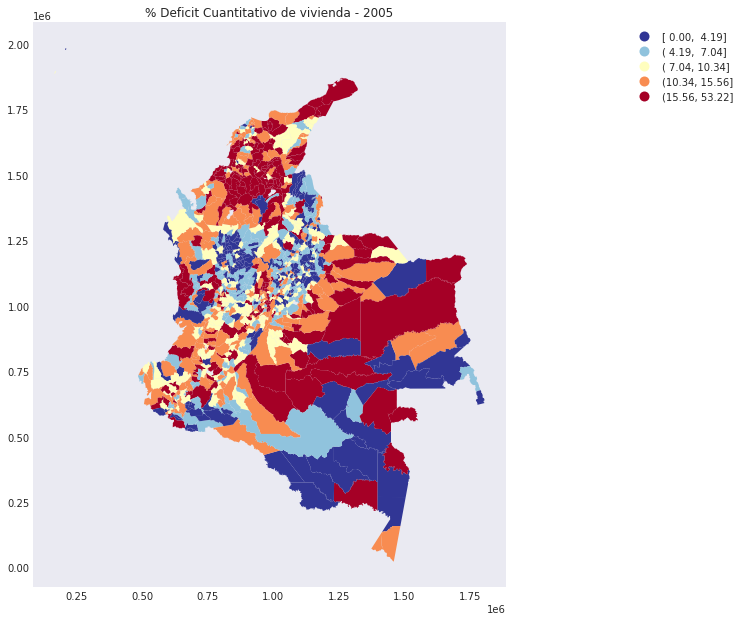

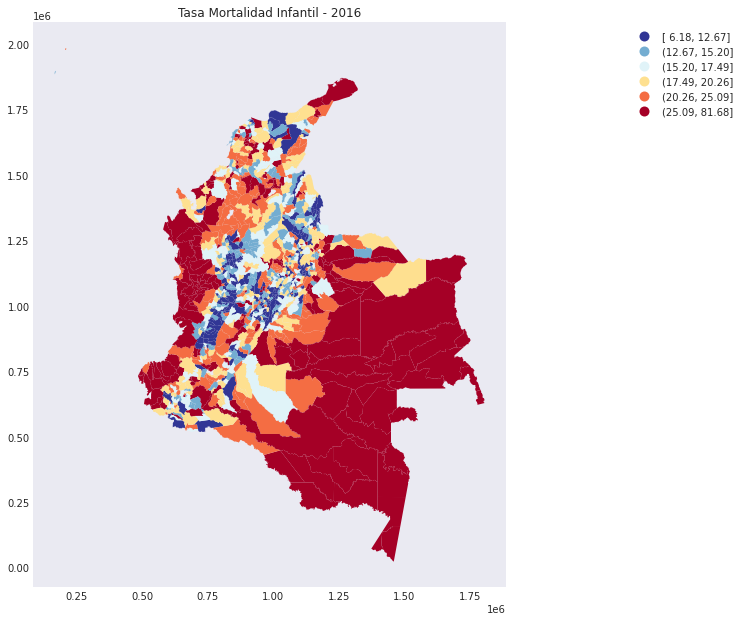

In [ ]:
### Deficit Cuantitativo Vivienda - 2005 - Nacional
with plt.style.context('seaborn-dark'):
  ax = Colombia.plot(column='Porcentaje',scheme='Quantiles',k=5, legend=True, cmap='RdYlBu_r',figsize=(9,9))
  plt.title('% Deficit Cuantitativo de vivienda - 2005')

# Defina ubicación de leyenda
  leg = ax.get_legend()
  leg.set_bbox_to_anchor((1.5,1))
  plt.tight_layout()

### Tasa Mortalidad Infantil - 2016 - Nacional
with plt.style.context('seaborn-dark'):
  bx = Colombia.plot(column='2016',scheme='Quantiles',k=6, legend=True, cmap='RdYlBu_r', figsize=(9,9))
  plt.title('Tasa Mortalidad Infantil - 2016')

# Defina ubicación de leyenda
  leg = bx.get_legend()
  leg.set_bbox_to_anchor((1.5,1))
  plt.tight_layout()

# Obtener Región 05


In [ ]:
print('Tipos de columna en <<Colombia>>\n\n', Colombia.dtypes)

Tipos de columna en <<Colombia>>

 OBJECTID        object
codigo           int64
AREA_OFICI     float64
ENTIDAD_TE      object
NOM_DEPART      object
NOM_MUNICI      object
COD_DEPTO       object
SHAPE_area     float64
SHAPE_len      float64
DIVIPOLA        object
geometry      geometry
Código_Dep       int64
Nombre_Dep      object
Nombre_Mun      object
Total          float64
Porcentaje     float64
Municipio       object
2016           float64
dtype: object


In [ ]:
#  La variable <codigo> aparece como tipo object en <col>. Pero en <DeficitCuantitativo2005> es de tipo
# <integer>. Por tanto, convierta la columna <codigo> en <col> a tipo 'integer'
#col['codigo'] = col['codigo'].astype('int')
Colombia.COD_DEPTO=Colombia.COD_DEPTO.astype('int')

print('\n',Colombia.COD_DEPTO.dtypes)



 int64


In [ ]:
Region05  = Colombia[Colombia.COD_DEPTO.isin(['11','15','25','50','81','85'])]
Region05.rename(columns={'2016':'TMI2016'}, inplace=True)
Region05

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,OBJECTID,codigo,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,SHAPE_area,SHAPE_len,DIVIPOLA,geometry,Código_Dep,Nombre_Dep,Nombre_Mun,Total,Porcentaje,Municipio,TMI2016
67,68,50350,11231.0,Cabecera Municipal,META,LA MACARENA,50,1.075145e+10,573172.471517,50350,"POLYGON ((941494.448 783596.987, 942886.614 78...",50,Meta,La Macarena,248.00,23.46,La Macarena,19.993532
68,69,50370,6307.0,Cabecera Municipal,META,URIBE,50,6.479806e+09,520446.251823,50370,"POLYGON ((1015933.340 772441.314, 1015932.748 ...",50,Meta,Uribe,260.00,13.00,Uribe,37.275772
69,70,50330,1980.0,Cabecera Municipal,META,MESETAS,50,2.259093e+09,343998.776294,50330,"POLYGON ((982030.411 893683.609, 982135.202 89...",50,Meta,Mesetas,96.00,7.71,Mesetas,21.569163
70,71,50683,1163.0,Cabecera Municipal,META,SAN JUAN DE ARAMA,50,1.175292e+09,227541.349960,50683,"POLYGON ((1037196.923 864183.876, 1036806.614 ...",50,Meta,San Juan de Arama,161.00,9.17,San Juan de Arama,27.205068
71,72,50287,576.0,Cabecera Municipal,META,FUENTE DE ORO,50,5.792059e+08,136218.142746,50287,"POLYGON ((1037196.923 864183.876, 1037213.800 ...",50,Meta,Fuente de Oro,533.00,18.13,Fuente de Oro,23.484490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,965,25781,67.0,Cabecera Municipal,CUNDINAMARCA,SUTATAUSA,25,6.721062e+07,38410.870365,25781,"POLYGON ((1023110.198 1075348.162, 1023252.463...",25,Cundinamarca,Sutatausa,47.00,3.70,Sutatausa,13.241167
958,966,25873,235.0,Cabecera Municipal,CUNDINAMARCA,VILLAPINZÓN,25,2.255639e+08,83321.436580,25873,"POLYGON ((1060027.709 1059029.261, 1060030.603...",25,Cundinamarca,Villapinzón,276.81,7.15,Villapinzón,14.881024
959,967,25224,110.0,Cabecera Municipal,CUNDINAMARCA,CUCUNUBÁ,25,1.097520e+08,59971.731743,25224,"POLYGON ((1044068.011 1069554.647, 1043992.000...",25,Cundinamarca,Cucunubá,108.00,6.66,Cucunubá,19.652864
960,968,25288,87.0,Cabecera Municipal,CUNDINAMARCA,FÚQUENE,25,8.411941e+07,45350.710970,25288,"POLYGON ((1033775.032 1083015.178, 1033774.170...",25,Cundinamarca,Fúquene,57.00,4.32,Fúquene,13.175230


# Mapas Corropletos - Región 05

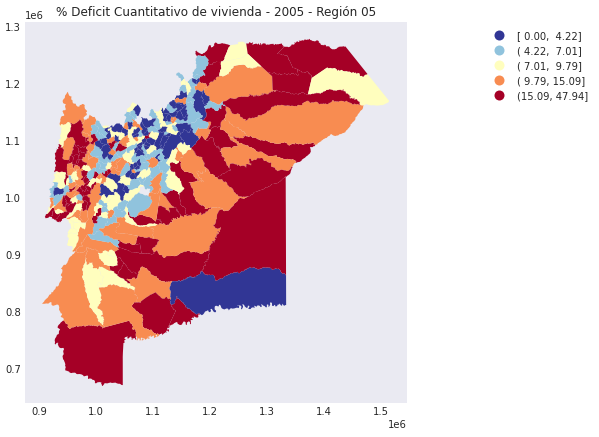

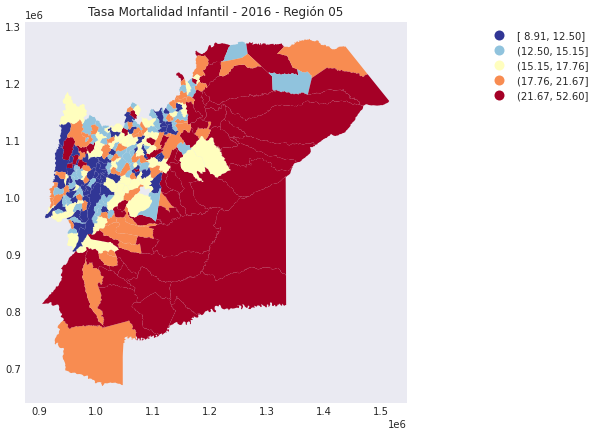

In [ ]:
# Deficit Vivienda 2005 Región 5
with plt.style.context('seaborn-dark'):
  cx = Region05.plot(column='Porcentaje',scheme='Quantiles',k=5, legend=True, cmap='RdYlBu_r',figsize=(9,9))
  plt.title('% Deficit Cuantitativo de vivienda - 2005 - Región 05')

# Defina ubicación de leyenda
  leg = cx.get_legend()
  leg.set_bbox_to_anchor((1.5,1))
  plt.tight_layout()

# Tasa Mortalidad Infantil 2016 Región 5
with plt.style.context('seaborn-dark'):
  dx = Region05.plot(column='TMI2016',scheme='Quantiles',k=5, legend=True, cmap='RdYlBu_r', figsize=(9,9))
  plt.title('Tasa Mortalidad Infantil - 2016 - Región 05')

# Defina ubicación de leyenda
  leg = dx.get_legend()
  leg.set_bbox_to_anchor((1.5,1))
  plt.tight_layout()

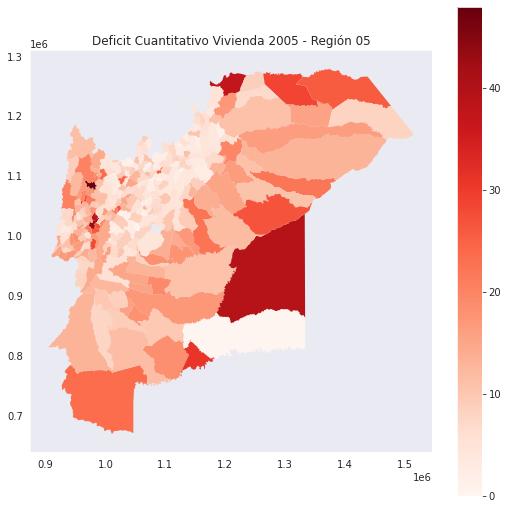

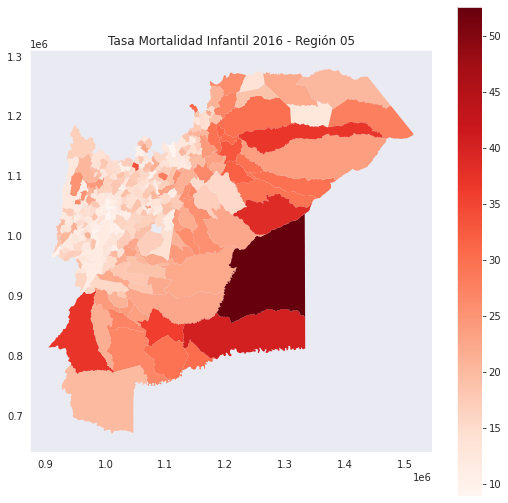

In [ ]:
with sns.axes_style('dark'):
 Region05.plot(column='Porcentaje',cmap='Reds',
          legend=True, edgecolor='None',figsize=(9,9))
 plt.title('Deficit Cuantitativo Vivienda 2005 - Región 05')

 Region05.plot(column='TMI2016',cmap='Reds',
          legend=True, edgecolor='None',figsize=(9,9))
 plt.title('Tasa Mortalidad Infantil 2016 - Región 05')

Tanto para el Deficit Cuantitativo de Vivienda como para la Tasa de Mortalidad Infantil se observa un alto porcentaje en la zona oriente, sur y nororiente, indicando lugares con altas difícultades sociales en materia de vivienda y mortalidad infantil, siendo así la posibilidad de causalidad entre estas. Dichas regiones equivalen a Arauca, Meta y Casanare.


Mientras que en el centro de la región en el noroccidente se ve una mejor calidad de vida, antes porcentajes más bajos de estas variables sobre todo en la región Cundinamarca y Boyacá, que pertenecen al centro del país y que por su política y economía tan centralizado refuerzan esta condición.

# Matriz de pesos espaciales

In [ ]:
Region05.index # Inspeccione el índice o identificador interno de fila

Int64Index([ 67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
            ...
            952, 953, 954, 955, 956, 957, 958, 959, 960, 961],
           dtype='int64', length=295)

In [ ]:
Region05.sort_values('codigo',ascending=True,inplace=True) # Ordene de manera ascendente
Region05.set_index('codigo',drop=False,inplace=True) # Establezca una variable de 
              # de los datos como el índice, pero consérvela como una columna.
Region05.index # Inspeccione el índice

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Int64Index([11001, 15001, 15022, 15047, 15051, 15087, 15090, 15092, 15097,
            15104,
            ...
            85250, 85263, 85279, 85300, 85315, 85325, 85400, 85410, 85430,
            85440],
           dtype='int64', name='codigo', length=295)

In [ ]:
# Matriz de pesos espaciales tipo Reina
wqs = Queen.from_dataframe(Region05,idVariable='codigo') # Genere vecindades tipo Reina
wqs.transform = 'r' # Genere pesos espaciales estandarizados por fila
print('Matriz W',wqs)
print('\nproporción enlaces no nulos', "%.3f"%wqs.pct_nonzero,'\n')


Matriz W <libpysal.weights.contiguity.Queen object at 0x7fb6fcf9e3c8>

proporción enlaces no nulos 1.896 



In [ ]:
# Inspeccione los pesos de Bogotá (divipola==11001)
wqs[11001]

{25053: 0.05555555555555555,
 25120: 0.05555555555555555,
 25175: 0.05555555555555555,
 25178: 0.05555555555555555,
 25181: 0.05555555555555555,
 25214: 0.05555555555555555,
 25286: 0.05555555555555555,
 25339: 0.05555555555555555,
 25377: 0.05555555555555555,
 25473: 0.05555555555555555,
 25535: 0.05555555555555555,
 25649: 0.05555555555555555,
 25754: 0.05555555555555555,
 25841: 0.05555555555555555,
 25845: 0.05555555555555555,
 50223: 0.05555555555555555,
 50318: 0.05555555555555555,
 50370: 0.05555555555555555}

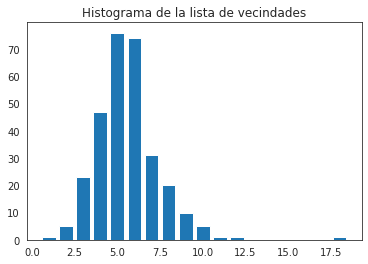

In [ ]:
with sns.axes_style('white'):
 hist_wqs = np.array(wqs.histogram,ndmin=2)
 plt.bar(hist_wqs[:,0],hist_wqs[:,1])
 plt.title('Histograma de la lista de vecindades')

La cantidad más frecuente de vecindades se encuentran en un rango entre 5 y 7.5 vecinos. Tomando en cuenta el criterio "reina" con el que se está llevando a cabo estos análisis.

In [ ]:
# Rezago espacial
Region05['lag_DCV2005'] = weights.lag_spatial(wqs, Region05['Porcentaje'])
Region05['lag_TMI2016'] = weights.lag_spatial(wqs, Region05['TMI2016'])

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:1107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Índice de Moran - Región 05

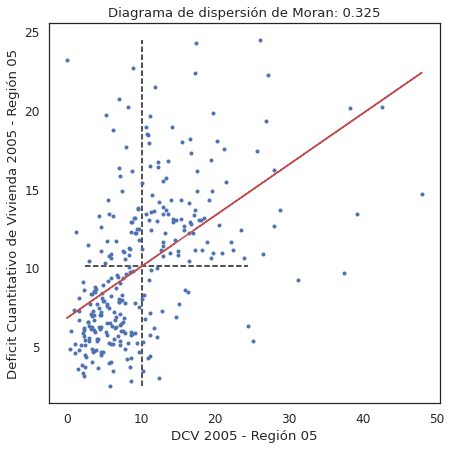

In [ ]:
# Diagrama de dispersión de Moran 
# Deficit Cuantitativo Vivienda 2005
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 7]})

b, a = np.polyfit(Region05.Porcentaje, Region05.lag_DCV2005, 1)

plt.plot(Region05['Porcentaje'],Region05['lag_DCV2005'],'.')

# dashed vert at mean of the price
plt.vlines(Region05.Porcentaje.mean(), 
           Region05.lag_DCV2005.min(), Region05.lag_DCV2005.max(),
           linestyle='--')
# dashed horizontal at mean of lagged price
plt.hlines(Region05.Porcentaje.mean(), 
           Region05.lag_DCV2005.min(), Region05.lag_DCV2005.max(), 
           linestyle='--')

# red line of best fit using global I as slope
plt.plot(Region05.Porcentaje, a + b*Region05.Porcentaje, 'r')
plt.title('Diagrama de dispersión de Moran: ' + str(b.round(3)) )
plt.ylabel('Deficit Cuantitativo de Vivienda 2005 - Región 05')
plt.xlabel('DCV 2005 - Región 05')
plt.show()

El diagrama de dispersión encuentra un alto agrupamiento en los recuadros de bajo-bajo y alto-alto, con alguna particularidad en el bajo-alto, lo cual me demuestra una dependencia espacial positiva y que tiende a ser significativa, lo cual se demostrará con el I de Moran de esta variable.

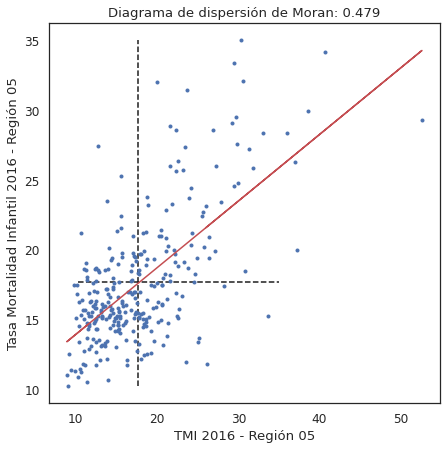

In [ ]:
# Tasa Mortalidad Infantil 2016
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 7]})

b, a = np.polyfit(Region05.TMI2016, Region05.lag_TMI2016, 1)

plt.plot(Region05['TMI2016'],Region05['lag_TMI2016'],'.')

# dashed vert at mean of the price
plt.vlines(Region05.TMI2016.mean(), 
           Region05.lag_TMI2016.min(), Region05.lag_TMI2016.max(),
           linestyle='--')
# dashed horizontal at mean of lagged price
plt.hlines(Region05.TMI2016.mean(), 
           Region05.lag_TMI2016.min(), Region05.lag_TMI2016.max(), 
           linestyle='--')

# red line of best fit using global I as slope
plt.plot(Region05.TMI2016, a + b*Region05.TMI2016, 'r')
plt.title('Diagrama de dispersión de Moran: ' + str(b.round(3)) )
plt.ylabel('Tasa Mortalidad Infantil 2016 - Región 05')
plt.xlabel('TMI 2016 - Región 05')
plt.show()

De la misma interpretación que la anterior, en este caso la mayor concentración se encuentra en la zona bajo-bajo, que da indicios de la dependencia espacial de la variable.

In [ ]:
# Índice de Moran Deficit Cuantitativo Vivienda 2005
mi_DCV2005 = Moran(Region05.Porcentaje.fillna(100),wqs, permutations=10000)
print('Deficit Cuantitativo Vivienda 2005 - Índice de Moran :',round(mi_DCV2005.I, 3), '\n p-valor: ',round(mi_DCV2005.p_sim,5))

Deficit Cuantitativo Vivienda 2005 - Índice de Moran : 0.325 
 p-valor:  0.0001


El indice de Moran para el Deficit cuantitativo como lo teníamos previsto indica dependencia espacial postiva, además de que su valor p nos indica que es estadísticamente significativo.

Esto indica en términos generales a un nivel de confianza del 95% que en promedio el hecho que los vecinos tengan deficit cuantitativo de vivienda [incide en un 32,5% en que la variable de referencia tenga deficit cuantitativo de vivienda.] esta lectura no es precisa.

In [ ]:
# Índice de Moran Tasa Mortalidad Infantil 2016
mi_TMI2016 = Moran(Region05.TMI2016.fillna(100),wqs, permutations=10000)
print('Tasa Mortalidad Infantil 2016 - Índice de Moran :',round(mi_TMI2016.I, 3), '\n p-valor: ',round(mi_TMI2016.p_sim,5))

Tasa Mortalidad Infantil 2016 - Índice de Moran : 0.479 
 p-valor:  0.0001


El indice de Moran para el Deficit cuantitativo como lo teníamos previsto indica dependencia espacial positiva, además de que su valor p nos indica que es estadísticamente significativo.

Esto indica en términos generales a un nivel de confianza del 95% que en promedio el hecho que los vecinos tengan deficit cuantitativo de vivienda incide en un 47,9% en que la variable de referencia tenga tasa de mortalidad infantil.

Text(0.5, 1.0, 'Distribución simulada del estadístico de Moran - Deficit Cuantitativa de Vivienda 2005')

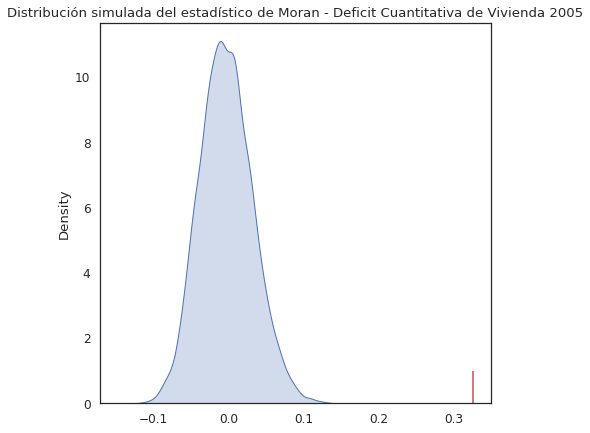

In [ ]:
mi_DCV2005.sim[0:5]
sns.kdeplot(mi_DCV2005.sim, shade=True) # Distribución simulada del Moran
plt.vlines(mi_DCV2005.I, 0, 1, color='r') # Moran Observado
plt.title('Distribución simulada del estadístico de Moran - Deficit Cuantitativa de Vivienda 2005')

Text(0.5, 1.0, 'Distribución simulada del estadístico de Moran - Tasa Mortalidad Infantil 2016')

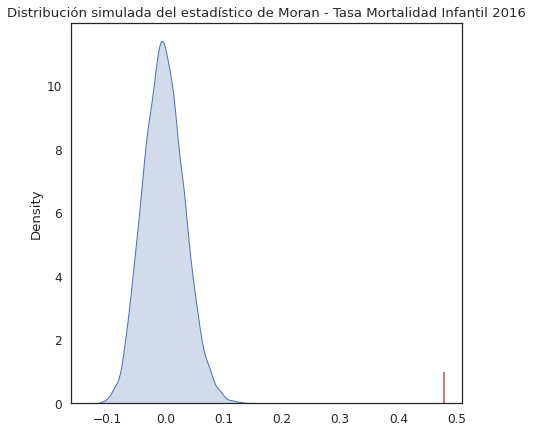

In [ ]:
mi_TMI2016.sim[0:5]
sns.kdeplot(mi_TMI2016.sim, shade=True) # Distribución simulada del Moran
plt.vlines(mi_TMI2016.I, 0, 1, color='r') # Moran Observado
plt.title('Distribución simulada del estadístico de Moran - Tasa Mortalidad Infantil 2016')


Dado que la distribución del estadístico de Moran no es simétrica, en consecuencia la literatura ha establecido como práctica estándar juzgar su significancia estadística por media de un *test de permutaciones* (ver Anselin, 1995).

# Indicadores Locales de Asociación Espacial - Región 05

In [ ]:
# calculate Moran_Local and plot
moran_loc_s_DCV2005_Region05 = Moran_Local(Region05.Porcentaje, wqs)
moran_loc_s_TMI2016_Region05 = Moran_Local(Region05.TMI2016, wqs)

In [ ]:
# Clusters
moran_loc_s_DCV2005_Region05.q

array([1, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 4,
       3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 2, 2,
       3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 4, 2, 3, 2, 1,
       3, 1, 1, 1, 3, 3, 2, 2, 2, 3, 3, 3, 1, 3, 2, 1, 1, 1, 3, 3, 1, 2,
       1, 3, 1, 3, 3, 1, 1, 4, 1, 3, 4, 2, 2, 3, 2, 2, 3, 3, 1, 1, 1, 1,
       3, 3, 1, 3, 2, 1, 2, 2, 1, 1, 1, 3, 1, 1, 3, 1, 1, 2, 3, 1, 4, 2,
       1, 1, 2, 3, 3, 1, 3, 2, 1, 1, 2, 3, 1, 4, 2, 1, 2, 4, 3, 4, 3, 1,
       2, 2, 3, 1, 1, 1, 3, 3, 4, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 4, 1, 1, 2, 1, 3,
       1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 3, 1, 2, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 1, 1])

In [ ]:
# Clusters
moran_loc_s_TMI2016_Region05.q

array([3, 3, 3, 1, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 1, 1, 2, 3,
       3, 4, 3, 3, 1, 1, 3, 1, 4, 3, 3, 1, 2, 3, 4, 4, 4, 3, 4, 3, 4, 1,
       2, 3, 1, 1, 3, 2, 2, 2, 3, 3, 3, 1, 3, 3, 4, 2, 3, 3, 3, 3, 3, 1,
       3, 2, 2, 3, 1, 3, 1, 1, 3, 4, 2, 1, 2, 2, 2, 3, 2, 4, 2, 3, 3, 4,
       2, 3, 3, 2, 1, 2, 4, 3, 1, 3, 3, 3, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3,
       2, 1, 2, 4, 3, 1, 3, 3, 3, 4, 4, 3, 2, 4, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 1, 4, 3, 3, 4, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 1, 2, 4, 3, 3, 3, 2, 4, 3,
       3, 4, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 1, 4, 2, 3, 2, 2, 4, 2, 4,
       3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 2, 4, 3, 2, 3, 3, 3, 4, 3, 3, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# P valores
moran_loc_s_DCV2005_Region05.p_sim 

array([0.148, 0.057, 0.018, 0.008, 0.007, 0.001, 0.128, 0.029, 0.065,
       0.011, 0.048, 0.049, 0.128, 0.051, 0.192, 0.01 , 0.018, 0.029,
       0.036, 0.181, 0.322, 0.034, 0.039, 0.062, 0.362, 0.036, 0.451,
       0.463, 0.182, 0.022, 0.169, 0.074, 0.166, 0.14 , 0.255, 0.086,
       0.066, 0.415, 0.077, 0.018, 0.071, 0.001, 0.099, 0.307, 0.004,
       0.008, 0.073, 0.335, 0.006, 0.097, 0.081, 0.1  , 0.153, 0.169,
       0.026, 0.024, 0.178, 0.268, 0.045, 0.367, 0.134, 0.005, 0.402,
       0.157, 0.017, 0.25 , 0.063, 0.485, 0.337, 0.149, 0.227, 0.004,
       0.003, 0.242, 0.14 , 0.046, 0.002, 0.17 , 0.004, 0.206, 0.067,
       0.202, 0.017, 0.128, 0.309, 0.128, 0.287, 0.195, 0.165, 0.294,
       0.065, 0.019, 0.004, 0.064, 0.313, 0.182, 0.004, 0.005, 0.004,
       0.173, 0.151, 0.088, 0.124, 0.203, 0.335, 0.142, 0.022, 0.03 ,
       0.023, 0.053, 0.086, 0.192, 0.486, 0.099, 0.095, 0.008, 0.1  ,
       0.067, 0.084, 0.21 , 0.008, 0.12 , 0.051, 0.016, 0.136, 0.404,
       0.265, 0.466,

In [ ]:
# P valores
moran_loc_s_TMI2016_Region05.p_sim

array([0.006, 0.486, 0.127, 0.082, 0.441, 0.207, 0.453, 0.121, 0.271,
       0.024, 0.083, 0.428, 0.429, 0.117, 0.048, 0.322, 0.265, 0.334,
       0.086, 0.003, 0.361, 0.453, 0.297, 0.11 , 0.451, 0.468, 0.341,
       0.163, 0.216, 0.4  , 0.259, 0.322, 0.031, 0.017, 0.1  , 0.023,
       0.123, 0.006, 0.463, 0.178, 0.269, 0.218, 0.071, 0.143, 0.405,
       0.161, 0.095, 0.207, 0.115, 0.23 , 0.217, 0.255, 0.272, 0.164,
       0.347, 0.204, 0.254, 0.467, 0.382, 0.332, 0.061, 0.293, 0.275,
       0.489, 0.296, 0.302, 0.016, 0.101, 0.186, 0.154, 0.007, 0.396,
       0.248, 0.005, 0.319, 0.486, 0.45 , 0.365, 0.286, 0.414, 0.213,
       0.229, 0.383, 0.316, 0.31 , 0.49 , 0.197, 0.21 , 0.331, 0.212,
       0.036, 0.387, 0.337, 0.327, 0.478, 0.484, 0.107, 0.45 , 0.12 ,
       0.339, 0.344, 0.346, 0.335, 0.45 , 0.155, 0.004, 0.458, 0.154,
       0.224, 0.001, 0.271, 0.218, 0.236, 0.318, 0.167, 0.231, 0.313,
       0.197, 0.252, 0.226, 0.157, 0.053, 0.262, 0.334, 0.23 , 0.023,
       0.184, 0.034,

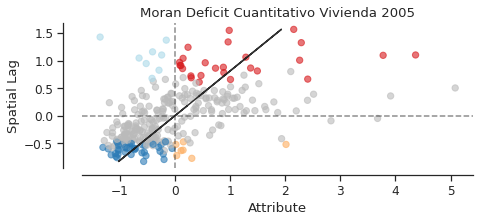

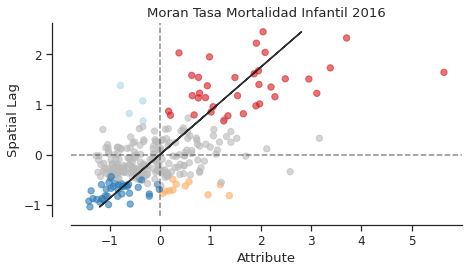

In [ ]:
# Diagrama de dispersión de Moran
with sns.axes_style("white"):
 moran_scatterplot(moran_loc_s_DCV2005_Region05, p=0.05)
 plt.title("Moran Deficit Cuantitativo Vivienda 2005")
 plt.show()

with sns.axes_style("white"):
 moran_scatterplot(moran_loc_s_TMI2016_Region05, p=0.05)
 plt.title("Moran Tasa Mortalidad Infantil 2016")
 plt.show()

Los LISA identificados en la gráfica de dispersión nos muestra la existencia de algunos cluster de agrupameinto en los 4 cuadrantes pero preponderando los cuadrantes bajo-bajo y alto-alto, en cada una de las dos variables.

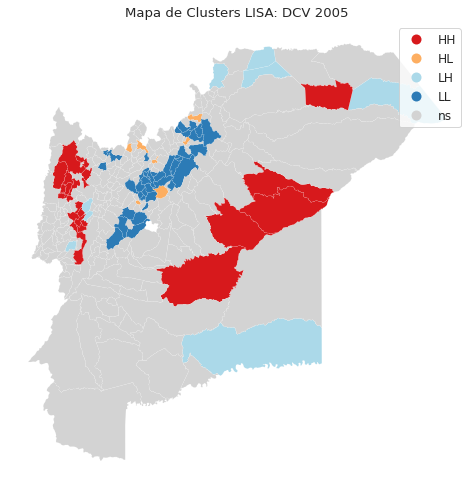

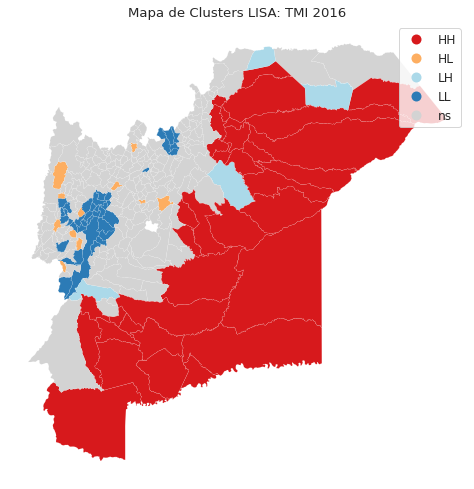

In [ ]:
# Mapa de clusters LISA
with sns.axes_style("white"):
 lisa_cluster(moran_loc_s_DCV2005_Region05, Region05, p=0.05, figsize=(7,7))
 plt.title('Mapa de Clusters LISA: DCV 2005')
 plt.tight_layout()
 plt.show()

with sns.axes_style("white"):
 lisa_cluster(moran_loc_s_TMI2016_Region05, Region05, p=0.05, figsize=(7,7))
 plt.title('Mapa de Clusters LISA: TMI 2016')
 plt.tight_layout()
 plt.show()

El LISA indica el tipo de patrón que se presenta alredador del vecindario de cada unidad espacial. Por ejemplo, es posible que aunque a nivel global, el índice de Moran sugiera que existe dependencia espacial positiva, a nivel local pueden exisitir algunos vecindarios de unidades espaciales que escapen a la tendencia, y por tanto exhibir correlación negativa o no exhibir ningún tipo de correlación, o viceversa.

El mapa de clusters LISA representa en un mapa coropleto las unidades espaciales para las cuales el índice local de Moran es estadísticamente significativo, y clasificadas según los agrupamientos definidos en el diagrama de dispersión de Moran.

En ambas variables planteadas, se observan algunas concentraciones (cluster) que me indican esos LISA.

Estos cluster indican que estos lugares tienen una particularidad y que sus vecinos también tengan una misma particularidad.

Es decir, en la agrupación alto alto indica, que los municipios de referencia tengan alto deficit o mortalidad y que todos vecinos también tengan esa misma caracteristica de alto deficit.

Caso contrario cuando tengo una baja mortalidad o deficit y que todos los vecinos a mi alrededor también tengan esa condicion baja, esto se conoce como el cuadrante bajo-bajo.

Hay unos casos expecionales donde la relación es inversa, alta mortalidad o deficit y que todos los vecinos aledaños tengan baja mortalidad o pobreza. conocida como la región alta-bajo. O en su defecto en caso contrario, sería la región bajo-Alto.

# Estadísticos Bivariado de Asociación Espacial - Región 05

In [ ]:
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

In [ ]:
moran_bv= Moran_BV(Region05.Porcentaje, Region05.TMI2016,wqs)
print('Índice de Moran : Rezago Espacial TMI 2016 vs. DCV 2005',round(moran_bv.I, 3), '\n p-valor: ',round(moran_bv.p_sim,5))

Índice de Moran : Rezago Espacial TMI 2016 vs. DCV 2005 0.126 
 p-valor:  0.001


La primera variable que se provee como argumento a dicha función es la que se rezaga espacialmente, en este caso, el Deficit Cuantitativo de Vivienda.

COMENTARIO: Realmente la que se rezaga es la segunda variable en la función.

Se encontró que el estadístico bivariado de Moran es positivo y significativo. Esto significa, en este caso, que en general los municipios con alto deficit cuantitativo espacial tienen vecinos con alta tasa de mortalidad infantil, o equivalmentente, que los municipios con bajo valor de hacinamiento (deficit cuantitativo de vivienda) tienen vecinos con un baja tasa de mortalidad infantil.

Se puede encontrar la relación positiva dela incidencia que tiene el haciento sobre la mortalidad infantil.


/usr/local/lib/python3.6/dist-packages/splot/_viz_esda_mpl.py:140: UserWarning:

`p` is only used for plotting `esda.moran.Moran_Local`
or `Moran_Local_BV` objects



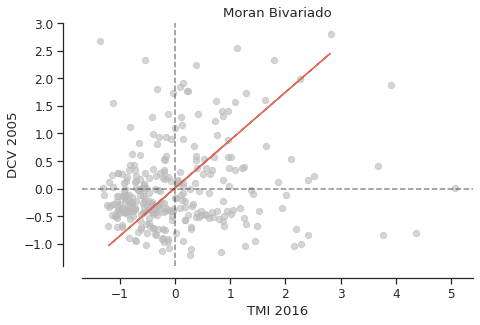

In [ ]:
# Diagrama de dispersión de Moran
with sns.axes_style("white"):
 moran_scatterplot(moran_bv, p=0.05)
 plt.title("Moran Bivariado")
 plt.xlabel('TMI 2016')
 plt.ylabel('DCV 2005')
 plt.show()

Gráficamente se puede identificar la relación entre estás dos variables, donde se evidencia el deficit habitacional está relacionada con la tasa de mortalidad infantil.

Esto indica que los municipios con alto deficit cuantitativo espacial, tienen vecinos con alta tasa de mortalidad infantil.
Dependencia espacial positiva.



Se puede identificar la tendecia espacial positiva entre estas dos variables y su incidencia. Por su pendiente positiva.

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:1107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



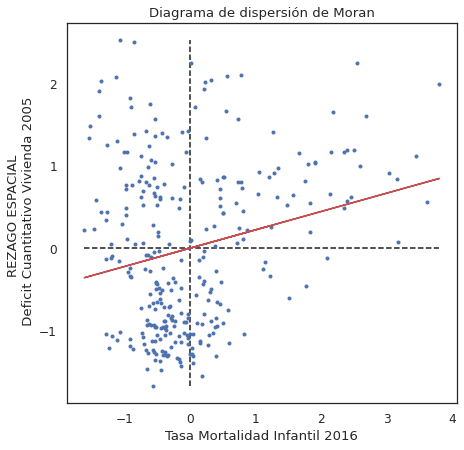

In [ ]:
# Rezago espacial
Region05['lag_DCV2005'] = weights.lag_spatial(wqs, Region05.lag_DCV2005)

from sklearn import preprocessing
x, y = preprocessing.scale(Region05.lag_TMI2016), preprocessing.scale(Region05.lag_DCV2005)

# Diagrama de dispersión de Moran bivariado
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 7]})

b, a = np.polyfit(x, y, 1)

plt.plot(x, y, '.')

# dashed vert at mean of the price
plt.vlines(x.mean(), 
           y.min(), y.max(),
           linestyle='--')
# dashed horizontal at mean of lagged price
plt.hlines(y.mean(), 
           x.min(),x.max(), 
           linestyle='--')

# red line of best fit using global I as slope
plt.plot(x, a + b*x, 'r')
plt.title('Diagrama de dispersión de Moran')
plt.ylabel('REZAGO ESPACIAL \n Deficit Cuantitativo Vivienda 2005')
plt.xlabel('Tasa Mortalidad Infantil 2016')
plt.show()

El diagrama de dispersión da muestras la dependencia que existe entre las dos variables, municipios con altas tasas de deficit habitacional tienen vecinos con galtas tasas de mortalidad infantil, o al revés, vecinos con bajas tasas de deficit habitacional tienen vecinos con baja tasa de mortalidad infantil.

Acá su indicador tiene una concentración en la zona inferior de los cuadrantes. (Bajo-Bajo).

# Lisa Bivariados

COMENTARIO: no se necesita rezagar espacialemtne las variables que se proveen como argumento a la función `Moran_Local_BV`, a no ser que se persiga algún propósito particular con este proceder. La función `Moran_Local_BV` recibe como argumentos las variables sin rezagar, pues esta función calcula internamente el rezago espacial requerido.

In [ ]:
moran_loc_bv2 = Moran_Local_BV(Region05.lag_DCV2005,Region05.lag_TMI2016, wqs)

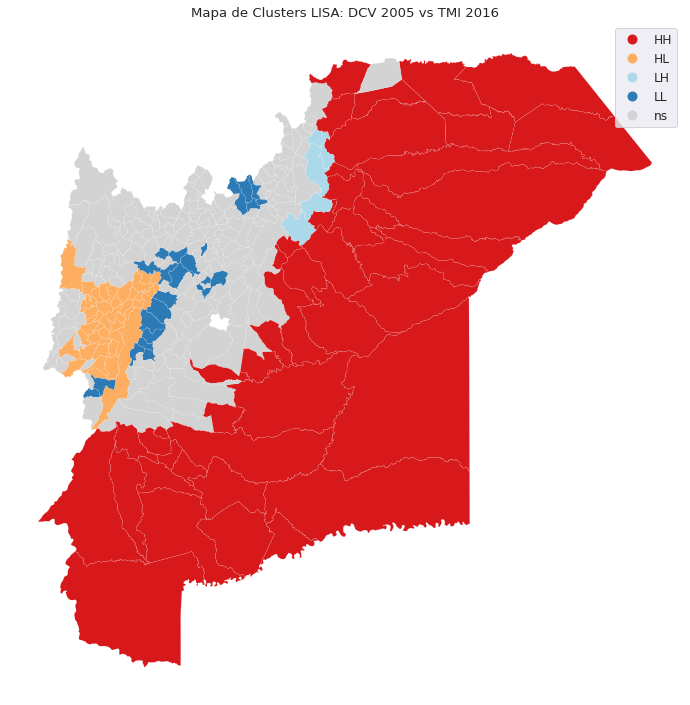

In [ ]:
with sns.axes_style("dark"):
 lisa_cluster(moran_loc_bv2, Region05, p=0.05, figsize=(10,10))
 plt.title('Mapa de Clusters LISA: DCV 2005 vs TMI 2016')
 plt.tight_layout()
 #plt.savefig('lisa_clusters.png')
 plt.show()

In [ ]:
moran_loc_bv = Moran_Local_BV(Region05.lag_TMI2016, Region05.lag_DCV2005 , wqs)

Se calculan los estadísticos bivariados de moran para el *rezago espacial del deficit cuantitativo de vivienda* y la *tasa de mortalidad infantil* municipal, 

El mapa de clusters resultante muestra que los agrupamientos más comunes son 1) el (Alto-Alto) y 2) el (Bajo-Bajo), situación coherente con el valor positivo obtenido para el estadístico global de Moran bivariado. Esto significa que los vecindarios más comunes son aquellos donde se tienen municipios 1) con alta tasa de mortalidad infantil cuyos vecinos tienen alto porcentaje de hacinamiento 2) con baja tasa de mortalidad infantil cuyos vecinos tienen baja  porcentaje de hacinamiento.

En este ejercicio la tendencia general de autocorrelación espacial es positiva (HH y LLs. En el agrupamiento HH (Alto-Alto) se tendrían municipios con alto valor agregado per cápita cuyos vecinos tienen alta incidencia de la pobreza multidimiensional rural. En el LL (Bajo-Bajo) se tendría la situación opuesta.

Hay excepciones donde se pueden ver valores atípicos donde se puede observar cluster donde la variable refrencia tiene alto nivel de deficit habitacional pero que sus vecinos tienen baja tasa de mortalidad infantil. Esta concentración conocida como Alto-bajo está en la zona occidental de la ciduad aledaña aBogotá.

En el mismo sentido, se encuentran casos de baja deficit de hacinamiento pero con vecinos con altos tasas de mortalidad infantil justo en la línea donde se concentra el cluster de alto a alto.

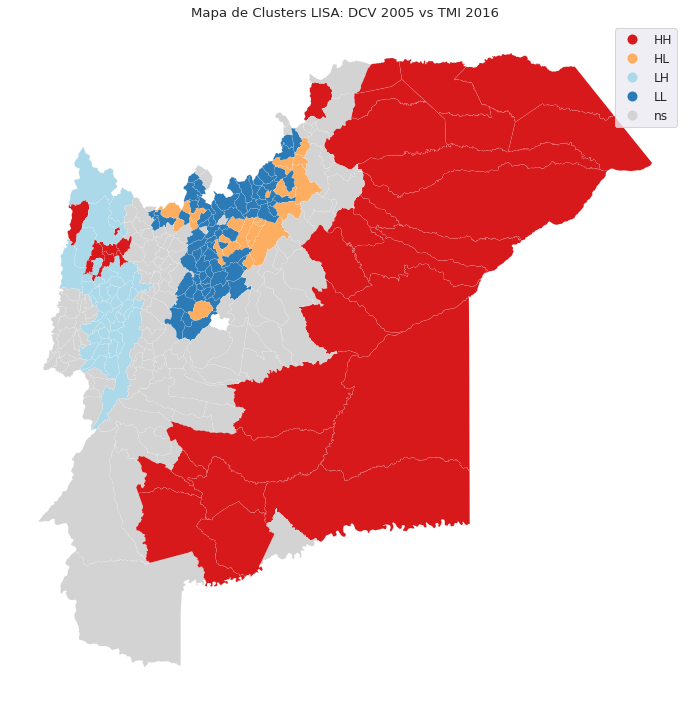

In [ ]:
with sns.axes_style("dark"):
 lisa_cluster(moran_loc_bv, Region05, p=0.05, figsize=(10,10))
 plt.title('Mapa de Clusters LISA: DCV 2005 vs TMI 2016')
 plt.tight_layout()
 #plt.savefig('lisa_clusters.png')
 plt.show()

En este sentido se tiene la misma interpretación que el anterior, cambiando las zonas donde se encuentra el cluster Bajo Alto y Alto-Bajo invirtiendose con el anterior gráfica donde sus comportamientos son al revés.

También varía la ubicación de la zona Bajo-Bajo, mientras que la Alto-Alto se mantiene relativamente igual.